In [1]:
# import the necessary packages
import os

import torch

# base path of the dataset
DATASET_PATH = os.path.join("dataset", "train")
# define the path to the images and masks dataset
IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, "images")
MASK_DATASET_PATH = os.path.join(DATASET_PATH, "masks")
# define the test split
TEST_SPLIT = 0.15
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False
# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
NUM_EPOCHS = 100
BATCH_SIZE = 64
# define the input image dimensions
INPUT_IMAGE_WIDTH = 128
INPUT_IMAGE_HEIGHT = 128
# define threshold to filter weak predictions
THRESHOLD = 0.5
# define the path to the base output directory
BASE_OUTPUT = "output"
# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_tgs_salt.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

/root/miniconda3/envs/med/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import time

import cv2
import einops
import matplotlib.pyplot as plt
import numpy as np
import torch
from model import UNet
from sklearn.model_selection import train_test_split
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as xfmrs
from tqdm import tqdm

In [3]:
torch.cuda.set_device(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

device 1 NVIDIA GeForce RTX 3090


In [4]:
len(np.load("ct2019.npy"))

2329

In [4]:
class SegmentationDataset(Dataset):
    def __init__(self, imagePath, maskPath, start=0, end=2329, hu1=-900, hu2=100, xfmr=xfmrs.ToTensor(), xfmr_img=None):
        # store the image and mask filepaths, and augmentation
        # transforms
        self.imagePath = imagePath
        self.maskPath = maskPath
        self.xfmr = xfmr
        self.xfmri = xfmr_img
        self.start = start
        self.end = end
        self.hu1 = hu1
        self.hu2 = hu2

        self.imgs = np.load(self.imagePath)
        self.masks = np.load(self.maskPath)

    def __len__(self):
        # return the number of total samples contained in the dataset
        return self.end - self.start

    def __getitem__(self, idx):
        img = (self.imgs[idx + self.start][0].clip(self.hu1, self.hu2) - self.hu1) / (self.hu2 - self.hu1)
        mask = self.masks[idx + self.start][0]
        # apply the transformations to both image and its mask
        seed = torch.random.seed()

        torch.random.manual_seed(seed)
        img = self.xfmr(img.astype(np.float32))

        torch.random.manual_seed(seed)
        mask = self.xfmr(mask.astype(np.float32))

        if self.xfmri is not None:
            img = self.xfmri(img)
        # return a tuple of the image and its mask
        return (img, mask)

torch.Size([64, 1, 448, 448]) torch.Size([64, 1, 448, 448])


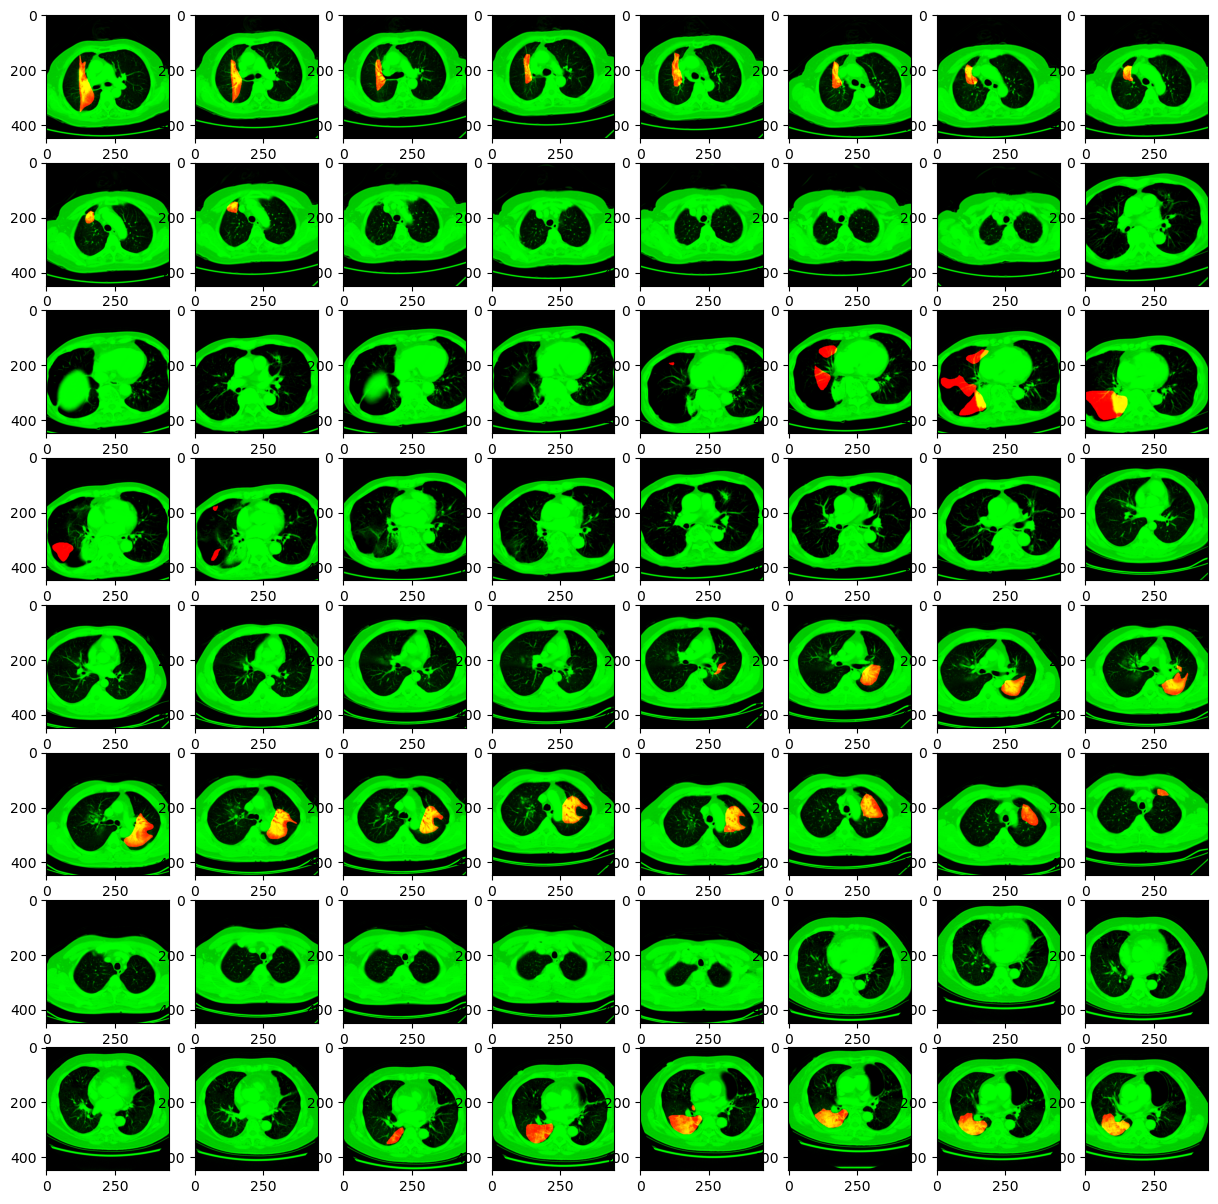

In [5]:
tds = SegmentationDataset(
    imagePath="ct2019.npy",
    maskPath="mask2019.npy",
    start=0,
    end=2000,
    hu1=-900,
    hu2=100,
    xfmr=xfmrs.Compose([xfmrs.ToTensor(), xfmrs.Resize((512, 512)), xfmrs.RandomCrop((448, 448))]),
    xfmr_img=xfmrs.Compose([xfmrs.Normalize(0.5, 0.5)]),
)
tdl = DataLoader(tds, batch_size=16, shuffle=True)

vds = SegmentationDataset(
    imagePath="ct2019.npy",
    maskPath="mask2019.npy",
    start=2000,
    end=2329,
    hu1=-900,
    hu2=100,
    xfmr=xfmrs.Compose([xfmrs.ToTensor(), xfmrs.Resize((512, 512)), xfmrs.RandomCrop((448, 448))]),
    xfmr_img=xfmrs.Compose([xfmrs.Normalize(0.5, 0.5)]),
)
vdl = DataLoader(vds, batch_size=BATCH_SIZE, shuffle=False)

for i, (imgs, masks) in enumerate(vdl):
    print(imgs.shape, masks.shape)
    plt.figure(figsize=(15, 15))
    for ii, (img, mask) in enumerate(zip(imgs, masks)):

        plt.subplot(8, 8, ii + 1)
        plt.imshow(
            einops.rearrange(np.array([mask.numpy()[0], img.numpy()[0] / 2 + 0.5, np.zeros((448, 448))]), "c h w -> h w c")
        )
    break

In [6]:
# initialize our UNet model
unet = UNet(encChannels=(1, 16, 32, 64), outSize=(448, 448)).to(device)
# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=INIT_LR)
# calculate steps per epoch for training and test set
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [ ]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
e_bar = tqdm(range(NUM_EPOCHS))
for e in e_bar:
    # set the model in training mode
    unet.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0
    # loop over the training set
    for (i, (x, y)) in enumerate(tdl):
        # send the input to the device
        (x, y) = (x.to(device), y.to(device))
        # perform a forward pass and calculate the training loss
        pred = unet(x)
        loss = lossFunc(pred, y)
        # first, zero out any previously accumulated gradients, then
        # perform backpropagation, and then update model parameters
        opt.zero_grad()
        loss.backward()
        opt.step()
        # add the loss to the total training loss so far
        totalTrainLoss += loss
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        unet.eval()
        # loop over the validation set
        for (x, y) in vdl:
            # send the input to the device
            (x, y) = (x.to(device), y.to(device))
            # make the predictions and calculate the validation loss
            pred = unet(x)
            totalTestLoss += lossFunc(pred, y)
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / len(tdl)
    avgTestLoss = totalTestLoss / len(vdl)
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    # print the model training and validation information
    e_bar.set_description("Processing ")
    print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...


Processing :   1%|▋                                                                     | 1/100 [00:13<21:37, 13.10s/it]

[INFO] EPOCH: 1/100
Train loss: 0.097724, Test loss: 0.0488


Processing :   2%|█▍                                                                    | 2/100 [00:24<20:01, 12.26s/it]

[INFO] EPOCH: 2/100
Train loss: 0.057746, Test loss: 0.0402


Processing :   3%|██                                                                    | 3/100 [00:36<19:22, 11.98s/it]

[INFO] EPOCH: 3/100
Train loss: 0.048596, Test loss: 0.0326


Processing :   4%|██▊                                                                   | 4/100 [00:48<18:56, 11.84s/it]

[INFO] EPOCH: 4/100
Train loss: 0.044947, Test loss: 0.0323


Processing :   5%|███▌                                                                  | 5/100 [00:59<18:35, 11.74s/it]

[INFO] EPOCH: 5/100
Train loss: 0.039254, Test loss: 0.0261


Processing :   6%|████▏                                                                 | 6/100 [01:11<18:18, 11.69s/it]

[INFO] EPOCH: 6/100
Train loss: 0.038721, Test loss: 0.0256


Processing :   7%|████▉                                                                 | 7/100 [01:22<18:06, 11.69s/it]

[INFO] EPOCH: 7/100
Train loss: 0.036890, Test loss: 0.0275


Processing :   8%|█████▌                                                                | 8/100 [01:34<17:51, 11.64s/it]

[INFO] EPOCH: 8/100
Train loss: 0.035871, Test loss: 0.0268


Processing :   9%|██████▎                                                               | 9/100 [01:46<17:41, 11.66s/it]

[INFO] EPOCH: 9/100
Train loss: 0.035369, Test loss: 0.0242


Processing :  10%|██████▉                                                              | 10/100 [01:57<17:28, 11.65s/it]

[INFO] EPOCH: 10/100
Train loss: 0.036432, Test loss: 0.0234


Processing :  11%|███████▌                                                             | 11/100 [02:09<17:14, 11.62s/it]

[INFO] EPOCH: 11/100
Train loss: 0.034462, Test loss: 0.0269


Processing :  12%|████████▎                                                            | 12/100 [02:20<17:01, 11.61s/it]

[INFO] EPOCH: 12/100
Train loss: 0.034528, Test loss: 0.0235


Processing :  13%|████████▉                                                            | 13/100 [02:32<16:51, 11.62s/it]

[INFO] EPOCH: 13/100
Train loss: 0.034434, Test loss: 0.0233


Processing :  14%|█████████▋                                                           | 14/100 [02:44<16:37, 11.60s/it]

[INFO] EPOCH: 14/100
Train loss: 0.033532, Test loss: 0.0244


Processing :  15%|██████████▎                                                          | 15/100 [02:55<16:25, 11.59s/it]

[INFO] EPOCH: 15/100
Train loss: 0.033442, Test loss: 0.0254


Processing :  16%|███████████                                                          | 16/100 [03:07<16:14, 11.60s/it]

[INFO] EPOCH: 16/100
Train loss: 0.033343, Test loss: 0.0256


Processing :  17%|███████████▋                                                         | 17/100 [03:18<16:02, 11.60s/it]

[INFO] EPOCH: 17/100
Train loss: 0.032531, Test loss: 0.0269


Processing :  18%|████████████▍                                                        | 18/100 [03:30<15:49, 11.58s/it]

[INFO] EPOCH: 18/100
Train loss: 0.032784, Test loss: 0.0233


Processing :  19%|█████████████                                                        | 19/100 [03:41<15:37, 11.57s/it]

[INFO] EPOCH: 19/100
Train loss: 0.032288, Test loss: 0.0215


Processing :  20%|█████████████▊                                                       | 20/100 [03:53<15:25, 11.57s/it]

[INFO] EPOCH: 20/100
Train loss: 0.031626, Test loss: 0.0246


Processing :  21%|██████████████▍                                                      | 21/100 [04:05<15:13, 11.56s/it]

[INFO] EPOCH: 21/100
Train loss: 0.031927, Test loss: 0.0222


Processing :  22%|███████████████▏                                                     | 22/100 [04:16<15:01, 11.55s/it]

[INFO] EPOCH: 22/100
Train loss: 0.031792, Test loss: 0.0215


Processing :  23%|███████████████▊                                                     | 23/100 [04:28<14:47, 11.53s/it]

[INFO] EPOCH: 23/100
Train loss: 0.031671, Test loss: 0.0233


Processing :  24%|████████████████▌                                                    | 24/100 [04:39<14:36, 11.54s/it]

[INFO] EPOCH: 24/100
Train loss: 0.030692, Test loss: 0.0212


Processing :  25%|█████████████████▎                                                   | 25/100 [04:51<14:25, 11.54s/it]

[INFO] EPOCH: 25/100
Train loss: 0.031088, Test loss: 0.0221


Processing :  26%|█████████████████▉                                                   | 26/100 [05:02<14:14, 11.54s/it]

[INFO] EPOCH: 26/100
Train loss: 0.030822, Test loss: 0.0212


Processing :  27%|██████████████████▋                                                  | 27/100 [05:14<14:03, 11.56s/it]

[INFO] EPOCH: 27/100
Train loss: 0.030659, Test loss: 0.0228


Processing :  28%|███████████████████▎                                                 | 28/100 [05:25<13:52, 11.56s/it]

[INFO] EPOCH: 28/100
Train loss: 0.030504, Test loss: 0.0258


Processing :  29%|████████████████████                                                 | 29/100 [05:37<13:41, 11.57s/it]

[INFO] EPOCH: 29/100
Train loss: 0.030410, Test loss: 0.0211


Processing :  30%|████████████████████▋                                                | 30/100 [05:49<13:30, 11.58s/it]

[INFO] EPOCH: 30/100
Train loss: 0.029598, Test loss: 0.0213


Processing :  31%|█████████████████████▍                                               | 31/100 [06:00<13:18, 11.57s/it]

[INFO] EPOCH: 31/100
Train loss: 0.029771, Test loss: 0.0220


Processing :  32%|██████████████████████                                               | 32/100 [06:12<13:07, 11.57s/it]

[INFO] EPOCH: 32/100
Train loss: 0.029371, Test loss: 0.0219


Processing :  33%|██████████████████████▊                                              | 33/100 [06:23<12:56, 11.58s/it]

[INFO] EPOCH: 33/100
Train loss: 0.029543, Test loss: 0.0209


Processing :  34%|███████████████████████▍                                             | 34/100 [06:35<12:44, 11.59s/it]

[INFO] EPOCH: 34/100
Train loss: 0.029452, Test loss: 0.0224


Processing :  35%|████████████████████████▏                                            | 35/100 [06:46<12:29, 11.53s/it]

[INFO] EPOCH: 35/100
Train loss: 0.028903, Test loss: 0.0211


Processing :  36%|████████████████████████▊                                            | 36/100 [06:58<12:24, 11.63s/it]

[INFO] EPOCH: 36/100
Train loss: 0.028512, Test loss: 0.0235


Processing :  37%|█████████████████████████▌                                           | 37/100 [07:10<12:08, 11.56s/it]

[INFO] EPOCH: 37/100
Train loss: 0.028776, Test loss: 0.0203


Processing :  38%|██████████████████████████▏                                          | 38/100 [07:21<12:00, 11.62s/it]

[INFO] EPOCH: 38/100
Train loss: 0.028671, Test loss: 0.0213


Processing :  39%|██████████████████████████▉                                          | 39/100 [07:33<11:45, 11.56s/it]

[INFO] EPOCH: 39/100
Train loss: 0.028940, Test loss: 0.0206


Processing :  40%|███████████████████████████▌                                         | 40/100 [07:44<11:31, 11.53s/it]

[INFO] EPOCH: 40/100
Train loss: 0.028291, Test loss: 0.0217


Processing :  41%|████████████████████████████▎                                        | 41/100 [07:56<11:20, 11.53s/it]

[INFO] EPOCH: 41/100
Train loss: 0.028895, Test loss: 0.0217


Processing :  42%|████████████████████████████▉                                        | 42/100 [08:07<11:07, 11.51s/it]

[INFO] EPOCH: 42/100
Train loss: 0.028826, Test loss: 0.0201


Processing :  43%|█████████████████████████████▋                                       | 43/100 [08:19<10:55, 11.50s/it]

[INFO] EPOCH: 43/100
Train loss: 0.027749, Test loss: 0.0214


Processing :  44%|██████████████████████████████▎                                      | 44/100 [08:30<10:43, 11.49s/it]

[INFO] EPOCH: 44/100
Train loss: 0.027738, Test loss: 0.0205


Processing :  45%|███████████████████████████████                                      | 45/100 [08:42<10:32, 11.50s/it]

[INFO] EPOCH: 45/100
Train loss: 0.028107, Test loss: 0.0222


Processing :  46%|███████████████████████████████▋                                     | 46/100 [08:53<10:20, 11.50s/it]

[INFO] EPOCH: 46/100
Train loss: 0.028232, Test loss: 0.0209


Processing :  47%|████████████████████████████████▍                                    | 47/100 [09:05<10:08, 11.48s/it]

[INFO] EPOCH: 47/100
Train loss: 0.027458, Test loss: 0.0205


Processing :  48%|█████████████████████████████████                                    | 48/100 [09:17<10:06, 11.66s/it]

[INFO] EPOCH: 48/100
Train loss: 0.027395, Test loss: 0.0208


Processing :  49%|█████████████████████████████████▊                                   | 49/100 [09:28<09:52, 11.62s/it]

[INFO] EPOCH: 49/100
Train loss: 0.027240, Test loss: 0.0206


Processing :  50%|██████████████████████████████████▌                                  | 50/100 [09:40<09:37, 11.55s/it]

[INFO] EPOCH: 50/100
Train loss: 0.027375, Test loss: 0.0212


Processing :  51%|███████████████████████████████████▏                                 | 51/100 [09:51<09:24, 11.51s/it]

[INFO] EPOCH: 51/100
Train loss: 0.027366, Test loss: 0.0200


Processing :  52%|███████████████████████████████████▉                                 | 52/100 [10:03<09:12, 11.50s/it]

[INFO] EPOCH: 52/100
Train loss: 0.027313, Test loss: 0.0199


Processing :  60%|█████████████████████████████████████████▍                           | 60/100 [11:35<07:47, 11.68s/it]

[INFO] EPOCH: 60/100
Train loss: 0.026211, Test loss: 0.0213


Processing :  61%|██████████████████████████████████████████                           | 61/100 [11:47<07:37, 11.73s/it]

[INFO] EPOCH: 61/100
Train loss: 0.026631, Test loss: 0.0203


Processing :  62%|██████████████████████████████████████████▊                          | 62/100 [11:59<07:27, 11.76s/it]

[INFO] EPOCH: 62/100
Train loss: 0.026196, Test loss: 0.0205


Processing :  63%|███████████████████████████████████████████▍                         | 63/100 [12:10<07:11, 11.67s/it]

[INFO] EPOCH: 63/100
Train loss: 0.026339, Test loss: 0.0199


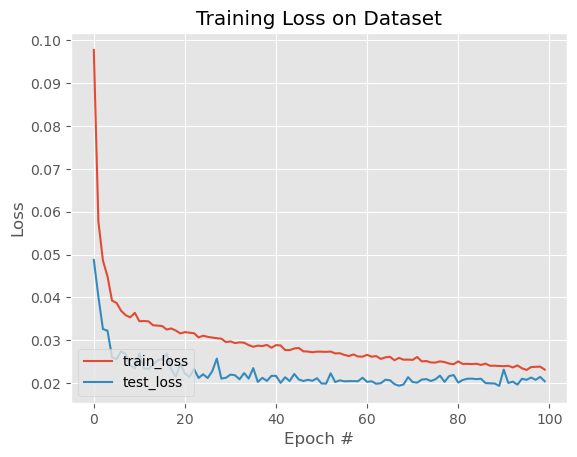

In [10]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("exp3.png")
# serialize the model to disk
torch.save(unet, "exp3.pth")

In [12]:
sorted([1, 2, 4, 3, 5])

[1, 2, 3, 4, 5]

In [54]:
# eval
th = 0.65
totalTestLoss, dices, ious = 0, 0, 0
best = []
with torch.no_grad():
    # set the model in evaluation mode
    unet.eval()
    # loop over the validation set
    for (x, y) in vdl:
        # send the input to the device
        (x, y) = (x.to(device), y.to(device))
        # make the predictions and calculate the validation loss
        pred = unet(x)
        totalTestLoss += lossFunc(pred, y)
        # plt.figure(figsize=(15, 15))
        for ii, (xx, yy, pp) in enumerate(zip(x.cpu().numpy(), y.cpu().numpy(), pred.cpu().numpy())):

            dice = (np.sum(yy[[pp[0] > th]]) * 2 + 0.1) / ((np.sum(yy[0]) + np.sum(pp[0] > th)) + 0.1)
            iou = (dice + 0.001) / (2.001 - dice)

            dices += dice
            ious += iou

            if (len(best) < 5 or best[-1][0] < iou) and iou != 1:
                best.append([iou, dice, xx, yy, pp])
                best = sorted(best, key=lambda x: x[0], reverse=True)
                if len(best) > 5:
                    best.pop()

            # plt.subplot(8, 8, ii + 1)
            # plt.imshow(
            #     einops.rearrange(
            #         np.array([yy[0] + xx[0] / 2 + 0.5, xx[0] / 2 + 0.5, (pp[0] > th) + xx[0] / 2 + 0.5]), "c h w -> h w c"
            #     )
            # )
            # plt.title(f"D{dice:.2f}, I{iou:.2f}")
            # plt.axis("off")
            # print(np.min(xx), np.max(xx), np.min(yy), np.max(yy), np.min(pp), np.max(pp) )
print(f"avg Dice = {dices/len(vds):.4f}, avg IoU = {ious/len(vds):.4f}, Valid Loss = {totalTestLoss/len(vdl):.4f}, ")

avg Dice = 0.5799, avg IoU = 0.5112, Valid Loss = 0.0204, 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


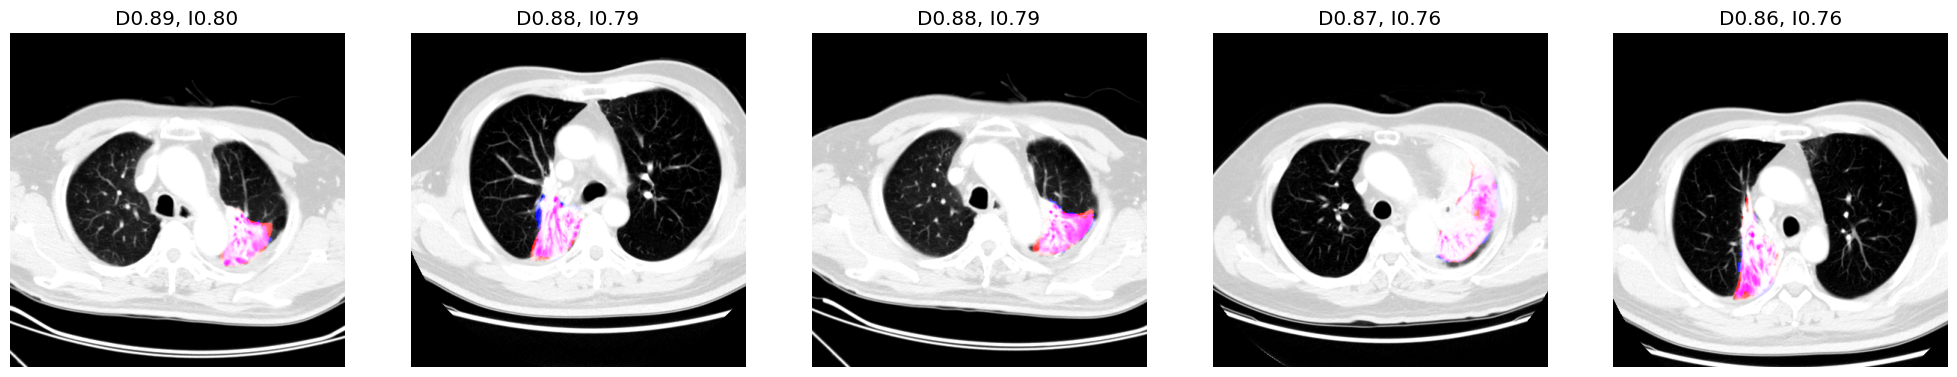

In [52]:
plt.figure(figsize=(25, 5))
for ii, (i, d, xxx, yyy, ppp) in enumerate(best):
    plt.subplot(1, 5, ii + 1)
    plt.imshow(
        einops.rearrange(
            np.array([yyy[0] + xxx[0] / 2 + 0.5, xxx[0] / 2 + 0.5, (ppp[0] > th) + xxx[0] / 2 + 0.5]), "c h w -> h w c"
        )
    )
    plt.title(f"D{d:.2f}, I{i:.2f}")
    plt.axis("off")
plt.savefig("exp3_b.png")
plt.show()

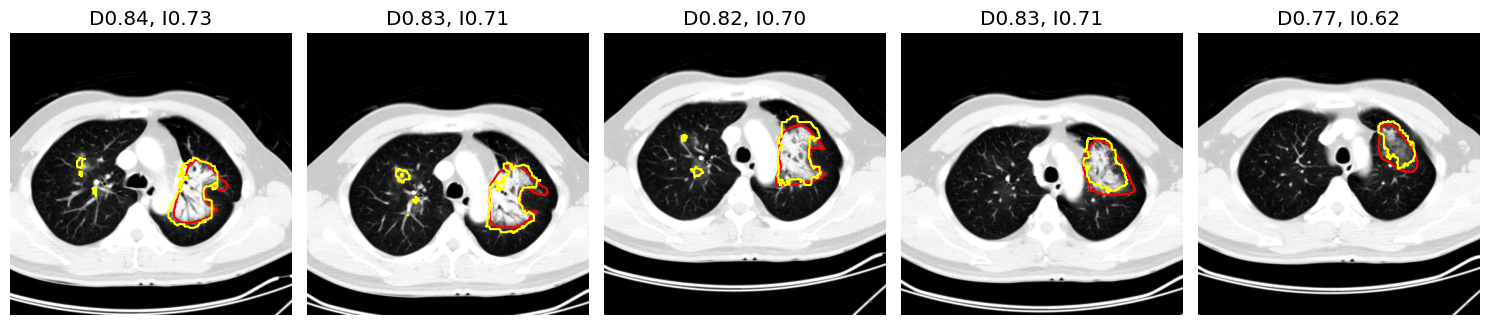

In [49]:
c1, c2 = 42, 47
th = 0.33
plt.figure(figsize=(15, 5))
for ii, (xx, yy, pp) in enumerate(zip(x.cpu().numpy()[c1:c2], y.cpu().numpy()[c1:c2], pred.cpu().numpy()[c1:c2])):

    dice = (np.sum(yy[[pp[0] > th]]) * 2 + 0.1) / ((np.sum(yy[0]) + np.sum(pp[0] > th)) + 0.1)
    iou = (dice + 0.001) / (2.001 - dice)

    dices += dice
    ious += iou

    plt.subplot(1, c2 - c1, ii + 1)
    plt.imshow(einops.rearrange([xx[0] / 2 + 0.5] * 3, "c h w -> h w c"))

    yc, _ = cv2.findContours(np.array(yy[0], np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    for c in yc:
        plt.plot(c[:, 0, 0], c[:, 0, 1], color="red")

    pc, _ = cv2.findContours(np.array(pp[0] > th, np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    for c in pc:
        plt.plot(c[:, 0, 0], c[:, 0, 1], color="yellow")

    plt.title(f"D{dice:.2f}, I{iou:.2f}")
    plt.axis("off")
plt.tight_layout()
plt.savefig("exp3_e.png")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


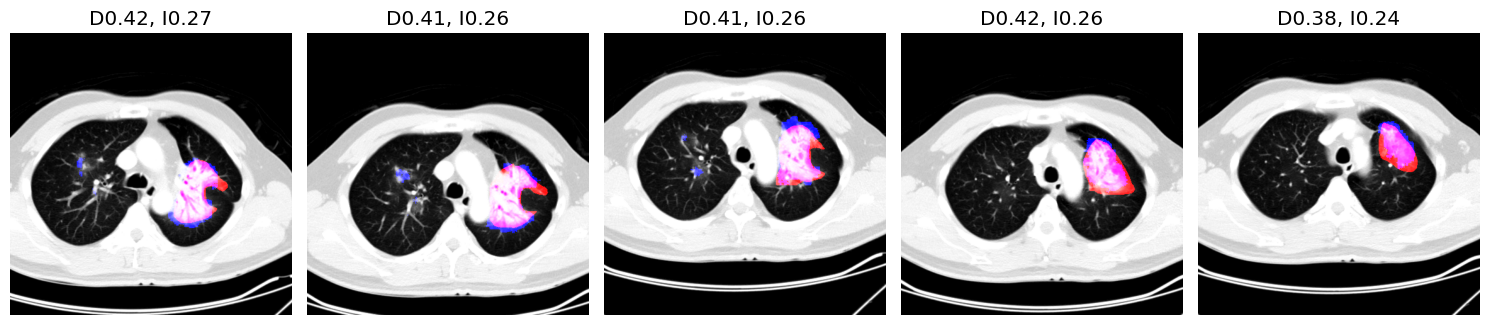

In [41]:
c1, c2 = 42, 47
th = 0.33
plt.figure(figsize=(15, 5))
for ii, (xx, yy, pp) in enumerate(zip(x.cpu().numpy()[c1:c2], y.cpu().numpy()[c1:c2], pred.cpu().numpy()[c1:c2])):

    dice = (np.sum(yy[[pp[0] > th]]) + 0.1) / ((np.sum(yy[0]) + np.sum(pp[0] > th)) + 0.1)
    iou = (dice + 0.001) / (2.001 - dice)

    dices += dice
    ious += iou

    plt.subplot(1, c2 - c1, ii + 1)
    plt.imshow(
        einops.rearrange(np.array([yy[0] + xx[0] / 2 + 0.5, xx[0] / 2 + 0.5, (pp[0] > th) + xx[0] / 2 + 0.5]), "c h w -> h w c")
    )
    plt.title(f"D{dice:.2f}, I{iou:.2f}")
    plt.axis("off")
plt.tight_layout()
plt.savefig("exp3_d.png")
plt.show()

max dice = (-0.88, 0.40), max iou = (-0.88, 0.25)


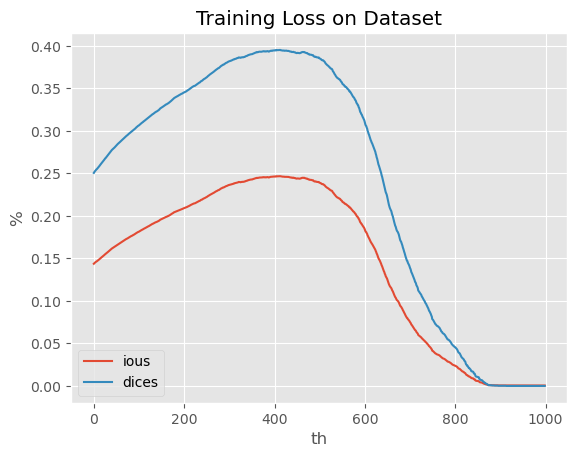

In [21]:
s_dice, s_iou = [], []
gg = 0
yc = y.cpu().numpy()
predc = pred.cpu().numpy()
for i in range(1, 1000):
    th = i * 0.01 - 5
    s_dice.append((np.sum(yc[gg][[predc[gg][0] > th]]) + 0.1) / ((np.sum(yc[gg][0]) + np.sum(predc[gg][0] > th)) + 0.1))
    s_iou.append((s_dice[-1] + 0.001) / (2.001 - s_dice[-1]))

plt.style.use("ggplot")
plt.figure()
plt.plot(s_iou, label="ious")
plt.plot(s_dice, label="dices")
plt.title("Training Loss on Dataset")
plt.xlabel("th")
plt.ylabel("%")
plt.legend(loc="lower left")

print(
    f"max dice = ({s_dice.index(np.max(s_dice))*0.01-5:.2f}, {np.max(s_dice):.2f}), max iou = ({s_iou.index(np.max(s_iou))*0.01-5:.2f}, {np.max(s_iou):.2f})"
)

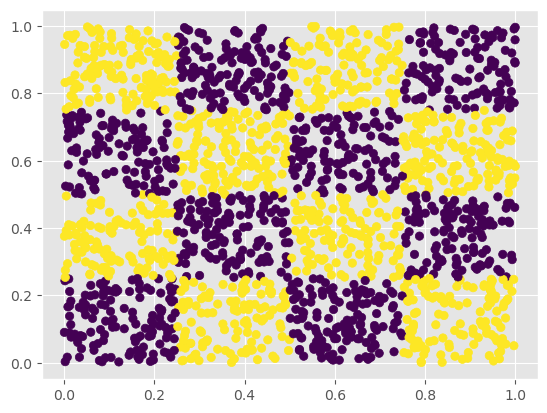

In [86]:
raw = np.array(
    [
        [
            x := np.random.random(),
            y := np.random.random(),
            (x < 0.25) ^ (x > 0.5) ^ (x > 0.75) ^ (y < 0.25) ^ (y > 0.5) ^ (y > 0.75),
        ]
        for i in range(2000)
    ]
)
plt.scatter(raw[:, 0], raw[:, 1], c=raw[:, 2])

In [116]:
import torch.nn as nn
def _gen_chessboard(n=100):
    """Data generation (Chessboard)

    Args:
        n (int):    the number of data points generated in total.

    Returns:
        data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
            a data point in 2d space.
        labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
            Each row represents a corresponding label (0 or 1).
    """    
    pos = np.array([(np.random.random(), np.random.random()) for i in range(n)])
    x, y = pos[:,0], pos[:,1]
    return pos, np.expand_dims(((x < 0.25) ^ (x > 0.5) ^ (x > 0.75) ^ (y < 0.25) ^ (y > 0.5) ^ (y > 0.75)).astype(np.int64), axis=0)

In [85]:
import matplotlib.pyplot as plt
import numpy as np


def sigmoid(x):
    """Sigmoid function.
    This function accepts any shape of np.ndarray object as input and perform sigmoid operation.
    """
    return 1 / (1 + np.exp(-x))


def der_sigmoid(y):
    """First derivative of Sigmoid function.
    The input to this function should be the value that output from sigmoid function.
    """
    return y * (1 - y)


class GenData:
    @staticmethod
    def _gen_linear(n=100):
        """Data generation (Linear)

        Args:
            n (int):    the number of data points generated in total.

        Returns:
            data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
                a data point in 2d space.
            labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
                Each row represents a corresponding label (0 or 1).
        """
        data = np.random.uniform(0, 1, (n, 2))

        inputs = []
        labels = []

        for point in data:
            inputs.append([point[0], point[1]])

            if point[0] > point[1]:
                labels.append(0)
            else:
                labels.append(1)

        return np.array(inputs), np.array(labels).reshape((-1, 1))

    @staticmethod
    def _gen_xor(n=100):
        """Data generation (XOR)

        Args:
            n (int):    the number of data points generated in total.

        Returns:
            data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
                a data point in 2d space.
            labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
                Each row represents a corresponding label (0 or 1).
        """
        data_x = np.linspace(0, 1, n // 2)

        inputs = []
        labels = []

        for x in data_x:
            inputs.append([x, x])
            labels.append(0)

            if x == 1 - x:
                continue

            inputs.append([x, 1 - x])
            labels.append(1)

        return np.array(inputs), np.array(labels).reshape((-1, 1))
    
    def _gen_chessboard(n=100):
        """Data generation (Chessboard)

        Args:
            n (int):    the number of data points generated in total.

        Returns:
            data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
                a data point in 2d space.
            labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
                Each row represents a corresponding label (0 or 1).
        """    
        pos = np.array([(np.random.random(), np.random.random()) for i in range(n)])
        x, y = pos[:,0], pos[:,1]
        return pos, ((x < 0.25) ^ (x > 0.5) ^ (x > 0.75) ^ (y < 0.25) ^ (y > 0.5) ^ (y > 0.75)).astype(np.int64)

    @staticmethod
    def _gen_chessboard(n=100):
        pos = np.array([[np.random.random(), np.random.random()] for i in range(n)])
        x, y = pos[:,0], pos[:,1]
        return pos, ((x < 0.25) ^ (x > 0.5) ^ (x > 0.75) ^ (y < 0.25) ^ (y > 0.5) ^ (y > 0.75)).astypr(bool)

    @staticmethod
    def fetch_data(mode, n):
        """Data gather interface

        Args:
            mode (str): 'Linear' or 'XOR', indicate which generator is used.
            n (int):    the number of data points generated in total.
        """
        assert mode == "Linear" or mode == "XOR"

        data_gen_func = {"Linear": GenData._gen_linear, "XOR": GenData._gen_xor}[mode]

        return data_gen_func(n)


class SimpleNet:
    def __init__(self, num_step=2000, print_interval=100):
        """A hand-crafted implementation of simple network.

        Args:
            num_step (optional):    the total number of training steps.
            print_interval (optional):  the number of steps between each reported number.
        """
        self.num_step = num_step
        self.print_interval = print_interval

        # Model parameters initialization
        # hidden layer 1: 100 nodes
        # hidden layer 2: 10 nodes
        # Please initiate your network parameters here.
        self.hidden1_weights = ...
        ...

    @staticmethod
    def plot_result(data, gt_y, pred_y):
        """Data visualization with ground truth and predicted data comparison. There are two plots
        for them and each of them use different colors to differentiate the data with different labels.

        Args:
            data:   the input data
            gt_y:   ground truth to the data
            pred_y: predicted results to the data
        """
        assert data.shape[0] == gt_y.shape[0]
        assert data.shape[0] == pred_y.shape[0]

        plt.figure()

        plt.subplot(1, 2, 1)
        plt.title("Ground Truth", fontsize=18)

        for idx in range(data.shape[0]):
            if gt_y[idx] == 0:
                plt.plot(data[idx][0], data[idx][1], "ro")
            else:
                plt.plot(data[idx][0], data[idx][1], "bo")

        plt.subplot(1, 2, 2)
        plt.title("Prediction", fontsize=18)

        for idx in range(data.shape[0]):
            if pred_y[idx] == 0:
                plt.plot(data[idx][0], data[idx][1], "ro")
            else:
                plt.plot(data[idx][0], data[idx][1], "bo")

        plt.show()

    def forward(self, inputs):
        """Implementation of the forward pass.
        It should accepts the inputs and passing them through the network and return results.
        """

        """ FILL IN HERE """

        return ...

    def backward(self):
        """Implementation of the backward pass.
        It should utilize the saved loss to compute gradients and update the network all the way to the front.
        """
        learning_rate = 1e-2

        """ FILL IN HERE """

    def train(self, inputs, labels):
        """The training routine that runs and update the model.

        Args:
            inputs: the training (and testing) data used in the model.
            labels: the ground truth of correspond to input data.
        """
        # make sure that the amount of data and label is match
        assert inputs.shape[0] == labels.shape[0]

        n = inputs.shape[0]

        for epochs in range(self.num_step):
            for idx in range(n):
                # operation in each training step:
                #   1. forward passing
                #   2. compute loss
                #   3. propagate gradient backward to the front
                self.output = self.forward(inputs[idx : idx + 1, :])
                self.error = self.output - labels[idx : idx + 1, :]
                """ apply your backward function: """
                """ FILL IN HERE """
                # self.backward()

            if epochs % self.print_interval == 0:
                print("Epochs {}: ".format(epochs))
                self.test(inputs, labels)

        print("Training finished")
        self.test(inputs, labels)

    def test(self, inputs, labels):
        """The testing routine that run forward pass and report the accuracy.

        Args:
            inputs: the testing data. One or several data samples are both okay.
                The shape is expected to be [BatchSize, 2].
            labels: the ground truth correspond to the inputs.
        """
        n = inputs.shape[0]

        error = 0.0
        for idx in range(n):
            result = self.forward(inputs[idx : idx + 1, :])
            error += abs(result - labels[idx : idx + 1, :])

        error /= n

        """ Print or plot your results in your preferred forms"""
        print("accuracy: %.2f" % ((1 - error) * 100) + "%")

        """ FILL IN HERE """
        # print('')